# Consult IT - preliminary elimination
## Team members (*Fratelli*):
1. Wiktor Jakubowski
2. Luca Nowosielski

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.cluster import AgglomerativeClustering

In [3]:
# load data
data = pd.read_excel('Baza_uczniów_CIT_2024.xlsx')
data.drop(['Imię', 'L.P.'], axis=1, inplace=True)

In [4]:
# check for missing values - there is none
data.isna().sum()

Płeć                     0
Wiek                     0
Język                    0
Poziom                   0
Hobby                    0
Typ prowadzenia zajęć    0
dtype: int64

In [20]:
### operations for categorical columns with order or binary values
ord_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

### operations for categorical unordered columns
cat_pipeline = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

### operations for numerical columns
num_pipeline = Pipeline(steps=[
    ('discretize', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'))
])

# Column transformer
col_trans = ColumnTransformer(transformers=[
    ('ord_pipeline', ord_pipeline, ['Płeć', 'Typ prowadzenia zajęć', 'Poziom']),
    ('cat_pipeline', cat_pipeline, ['Język', 'Hobby']),
    ('num_pipeline', num_pipeline, ['Wiek'])
],
remainder='drop',
n_jobs=-1)

# hierarchical clustering at the end of the pipeline (limit as desired number of people in the group)
model_pipeline = Pipeline([
    ('preprocessing', col_trans),
    #('clustering', AgglomerativeClustering(metric='euclidean', linkage='ward'))
])

In [21]:
# preprocess data
data_preprocessed = model_pipeline.fit_transform(data)

# convert compressed data to numpy array
decompressed_data = data_preprocessed.toarray()


/home/lmn20/anaconda3/envs/consult_it_env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


### Agglomerative clustering

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

##### (a) Without constraint on the number of clusters

In [30]:
AC_model = AgglomerativeClustering(metric='euclidean', linkage='ward')

# fit model
clustered_data = AC_model.fit_predict(decompressed_data)

In [32]:
# Initialize TSNE model with desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Perform t-SNE on the data
tsne_result = tsne.fit_transform(decompressed_data)

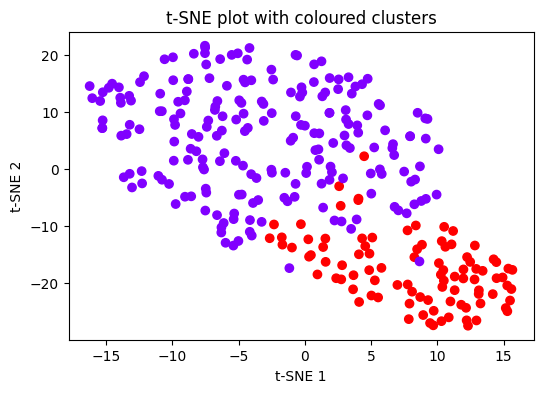

In [33]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clustered_data, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

##### (b) With constraint on the number of clusters

In [34]:
# define model for 30 clusters of 300 observations
AC_model_30 = AgglomerativeClustering(n_clusters = 30, metric='euclidean', linkage='ward')

# fit model
clustered_data_30 = AC_model_30.fit_predict(decompressed_data)

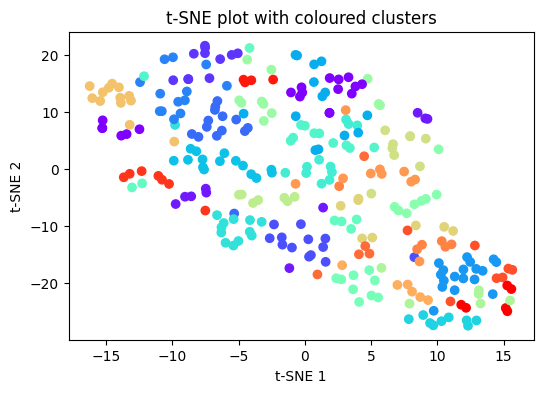

In [35]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clustered_data_30, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [40]:
# check the cluster sizes

cluster_sizes = []

for i in range(30):
    
    cluster_sizes.append(clustered_data_30.tolist().count(i))

print('The cluster sizes are: ', cluster_sizes)

The cluster sizes are:  [19, 10, 11, 13, 14, 13, 18, 14, 15, 9, 13, 11, 11, 7, 9, 8, 11, 6, 7, 9, 8, 13, 6, 10, 6, 5, 7, 7, 4, 6]


In [41]:
from sklearn.metrics import silhouette_score

In [42]:
fits = []
score = []

for clusters in range(30, 60):
    # train the model for current number of clusters
    model = AgglomerativeClustering(n_clusters = clusters, metric='euclidean', linkage='ward').fit_predict(decompressed_data)
    
    # append the model to fits
    fits.append(model)
    
    # append the silhouette score to scores
    score.append(silhouette_score(decompressed_data, model.labels_, metric='euclidean'))

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [44]:
fits

[array([27,  5, 23, 16, 26,  2,  2,  7,  3,  4, 21, 27, 13, 29,  0, 11, 12,
         0,  0, 20, 20, 18,  3,  7, 21,  7, 21,  3,  8, 14, 12, 28, 13, 24,
        17, 10, 24, 21, 23,  6, 26, 11,  5, 13,  0,  4, 12, 10, 14, 21,  3,
         6, 15, 12,  1, 14,  9, 23, 17,  1, 29, 11, 12,  9, 11, 16,  8, 19,
        15, 16,  4, 11, 14, 20,  9, 10, 16, 12,  0, 13,  0,  4,  4, 19,  8,
        22, 10,  0,  2, 24, 19,  6,  1,  0, 16, 20, 12,  6, 23,  3,  5,  8,
        20, 17,  7, 21, 11, 21,  1, 29,  0, 10, 29, 29,  0,  3,  4, 23,  6,
        25, 23, 14,  8, 19, 21, 27, 26,  7, 21, 10, 10, 20, 25, 15,  7, 14,
         5,  5, 11,  7, 12,  8,  2, 10,  2,  5, 10,  7,  3,  1,  9, 18,  6,
         4, 29,  8,  1, 13,  6,  4,  4,  6, 21, 28,  8, 21,  6,  6,  3, 15,
         2,  9, 28, 14,  2, 16,  6,  7, 16,  7,  0,  1, 24, 23,  5,  4, 26,
        25,  2, 16,  0,  4,  5, 15, 24,  4,  9, 27,  6,  8,  0, 12, 18, 16,
        11, 10,  4,  2, 22,  5, 17, 10,  8, 17, 11,  9,  2,  0, 19,  3, 27,
        22, 

In [43]:
model

array([27,  5, 23, 16, 26,  2,  2,  7,  3,  4, 21, 27, 13, 29,  0, 11, 12,
        0,  0, 20, 20, 18,  3,  7, 21,  7, 21,  3,  8, 14, 12, 28, 13, 24,
       17, 10, 24, 21, 23,  6, 26, 11,  5, 13,  0,  4, 12, 10, 14, 21,  3,
        6, 15, 12,  1, 14,  9, 23, 17,  1, 29, 11, 12,  9, 11, 16,  8, 19,
       15, 16,  4, 11, 14, 20,  9, 10, 16, 12,  0, 13,  0,  4,  4, 19,  8,
       22, 10,  0,  2, 24, 19,  6,  1,  0, 16, 20, 12,  6, 23,  3,  5,  8,
       20, 17,  7, 21, 11, 21,  1, 29,  0, 10, 29, 29,  0,  3,  4, 23,  6,
       25, 23, 14,  8, 19, 21, 27, 26,  7, 21, 10, 10, 20, 25, 15,  7, 14,
        5,  5, 11,  7, 12,  8,  2, 10,  2,  5, 10,  7,  3,  1,  9, 18,  6,
        4, 29,  8,  1, 13,  6,  4,  4,  6, 21, 28,  8, 21,  6,  6,  3, 15,
        2,  9, 28, 14,  2, 16,  6,  7, 16,  7,  0,  1, 24, 23,  5,  4, 26,
       25,  2, 16,  0,  4,  5, 15, 24,  4,  9, 27,  6,  8,  0, 12, 18, 16,
       11, 10,  4,  2, 22,  5, 17, 10,  8, 17, 11,  9,  2,  0, 19,  3, 27,
       22,  5,  0, 16,  2